
# Assignment-11: Apply Truncated SVD On Amazon Fine Food Reviews DataSet 

## Introduction 

(i).A random forest consists of multiple random decision trees. Two types of randomnesses are built into the trees. First, each tree is built on a random sample from the original data. Second, at each tree node, a subset of features are randomly selected to generate the best split.

## Objective

To Predict the Polarity of Amazon Fine Food Review Using Random Forest Algorithm.

## Importing All Required Library

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from gensim.models import Word2Vec
from gensim.models import KeyedVectors


import pickle


from tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")

C:\Users\User\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Importing Amazon Fine Food Review  Dataset

In [2]:
if os.path.isfile("final.sqlite"):
    conn=sqlite3.connect("final.sqlite")
    Data=pd.read_sql_query("select * from Reviews where Score!=3",conn)
    conn.close()
else :
    print("Error Importing the file")

In [3]:
# Printing some data of DataFrame

Data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [4]:
Data.columns

Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText'],
      dtype='object')

## Information About DataSet

In [5]:
print("\nNumber of Reviews: ",Data["Text"].count())
print("\nNumber of Users: ",len(Data["UserId"].unique())) # Unique returns 1-D array of unique values of DataFrame.
print("\nNumber of Products: ",len(Data["ProductId"].unique()))
print("\nShape of Data: ", Data.shape)
print("\nColumn Name of DataSet : ",Data.columns)
print("\n\nNumber of Attributes/Columns in data: 12") 
print("\nNumber of Positive Reviews : ", Data['Score'].value_counts()[1])
print("\nNumber of Negative Reviews : ", Data['Score'].value_counts()[0])


Number of Reviews:  364171

Number of Users:  243414

Number of Products:  65442

Shape of Data:  (364171, 12)

Column Name of DataSet :  Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText'],
      dtype='object')


Number of Attributes/Columns in data: 12

Number of Positive Reviews :  307061

Number of Negative Reviews :  57110


In [6]:
print("\nNumber of Reviews: ",Data["Text"].count())


Number of Reviews:  364171


## Attribute Information About DataSet

1.Id - A unique value starts from 1



2.ProductId - A unique identifier for the product



3.UserId - A unqiue identifier for the user



4.ProfileName - Name of user profile 



5.HelpfulnessNumerator - Number of users who found the review helpful



6.HelpfulnessDenominator - Number of users who indicated whether they found the review helpful or not



7.Score - Rating 0 or 1



8.Time - Timestamp for the review



9.Summary - Brief summary of the review



10.Text - Text of the review



11.Cleaned Text - Text that only alphabets

In [7]:
# Sorting on the basis of Time Parameter
Data.sort_values('Time',inplace=True)

In [8]:
Data=Data.head(100000)

In [9]:
Y = Data['Score']
X = Data['CleanedText']

## Defining Some Function

### Co-Variance Matrix

In [10]:
# Evaluate the Co-occurence matrix with context window '5'
def get_co_occur_matrix(data, vocab, context_window=5):
    a = pd.DataFrame(np.zeros((len(vocab), len(vocab))), index=vocab, columns=vocab)
    for review in data:
        words = review.split()
        for idx in range(len(words)):
            if a.get(words[idx]) is None:
                continue
            for i in range(1, context_window+1):
                if idx-i >= 0:
                    if a.get(words[idx-i]) is not None:
                        a[words[idx-i]].loc[words[idx]] = a.get(words[idx-i]).loc[words[idx]] + 1
                        a[words[idx]].loc[words[idx-i]] = a.get(words[idx]).loc[words[idx-i]] + 1
                if idx+i < len(words):
                    if a.get(words[idx+i]) is not None:
                        a[words[idx+i]].loc[words[idx]] = a.get(words[idx+i]).loc[words[idx]] + 1
                        a[words[idx]].loc[words[idx+i]] = a.get(words[idx]).loc[words[idx+i]] + 1
    np.fill_diagonal(a.values, 0)
    return a

### Word Cloud

In [11]:
def Word_Cloud(df):
    from wordcloud import WordCloud, STOPWORDS

    cloud = " ".join(word for word in df)
    stopwords = set(STOPWORDS) 
    wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 8)) 
    plt.imshow(wordcloud, interpolation = 'bilinear') 
    plt.axis("off") 
    #plt.title("Top 100 most important features\n")
    plt.tight_layout(pad = 0) 
  
    plt.show()

## TF-IDF Vectorizer

In [12]:
vectorizer_tfidf=TfidfVectorizer(max_features=15000,min_df=5)
vectors=vectorizer_tfidf.fit_transform(X)
vectors=preprocessing.normalize(vectors)

In [13]:

%%time
# Evaluate and store the top 3000 TFIDF Vectors and their corresponding words idf_ gives the weight
indices = np.argsort(vectorizer_tfidf.idf_)[::-1]
features = vectorizer_tfidf.get_feature_names()
top_n = 3000
top_feats = [features[i] for i in indices[:top_n]]
top_idf = [vectorizer_tfidf.idf_[i] for i in indices[:top_n]]

Wall time: 1.36 s


In [14]:
co_matrix = get_co_occur_matrix(X,top_feats)

In [15]:
counter = 0
for i in co_matrix.index:
    if counter == 20:
        break
    for j in co_matrix.index:
        if co_matrix.loc[j][i] != 0:
            print (i,j,"===>", co_matrix.loc[j][i])
            counter += 1

niederegg swede ===> 4.0
niederegg wwii ===> 4.0
nile percentil ===> 2.0
traditionalist staunch ===> 2.0
eliya nuwara ===> 10.0
eliya dimbula ===> 10.0
elmer fudd ===> 8.0
elmer coyot ===> 4.0
hornet wasp ===> 10.0
travesti putti ===> 2.0
salin sealer ===> 2.0
salin dna ===> 2.0
sandra dissatisfact ===> 2.0
nicu preemi ===> 2.0
hypocrit espous ===> 2.0
hypocrit bald ===> 2.0
crayon tar ===> 2.0
hyderabadi hyderabad ===> 4.0
hyderabad hyderabadi ===> 4.0
sarcast giver ===> 2.0


### Dim-reduction using Truncated SVD and get the Top Singular Values explaining the most variance

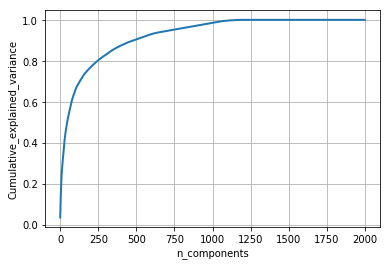

In [16]:
svd = TruncatedSVD(n_components=1999, random_state=42)
svd_matrix = svd.fit_transform(co_matrix)
cum_var_explained = np.cumsum(svd.explained_variance_ratio_)

# Plot the Truncated SVD spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

###  Minimum Components using  max explained variance

In [17]:
for i in range(len(cum_var_explained)):
    if cum_var_explained[i] >= 1.0:
        print(i)
        break

1202


### Finding the best valve number of cluster 

Starting Cluster #2
Starting Cluster #4
Starting Cluster #5
Starting Cluster #7
Starting Cluster #8
Starting Cluster #10
Starting Cluster #12
Starting Cluster #13
Starting Cluster #15


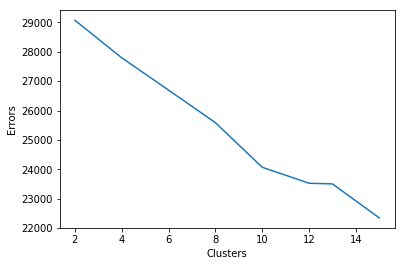

In [18]:
errors = []; clusters = [2, 4, 5, 7, 8, 10,12,13,15];
for i in clusters:
    print(f'Starting Cluster #{i}')
    model = KMeans(n_clusters=i, random_state=42, verbose=0)
    model.fit(svd_matrix)
    errors.append(model.inertia_)

plt.plot(clusters, errors)
plt.xlabel('Clusters')
plt.ylabel('Errors')
plt.show()

In [19]:
model = KMeans(n_clusters=12, random_state=42, verbose=0)
model.fit(svd_matrix)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [20]:
df=pd.DataFrame(svd_matrix)
df['Cluster_labels']=model.labels_
df['Words']= top_feats

Total no of Words in cluster 0 is 2984


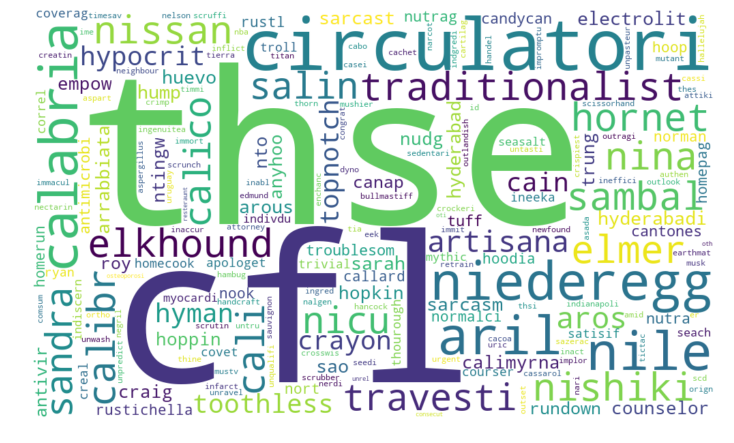

Total no of Words in cluster 1 is 1


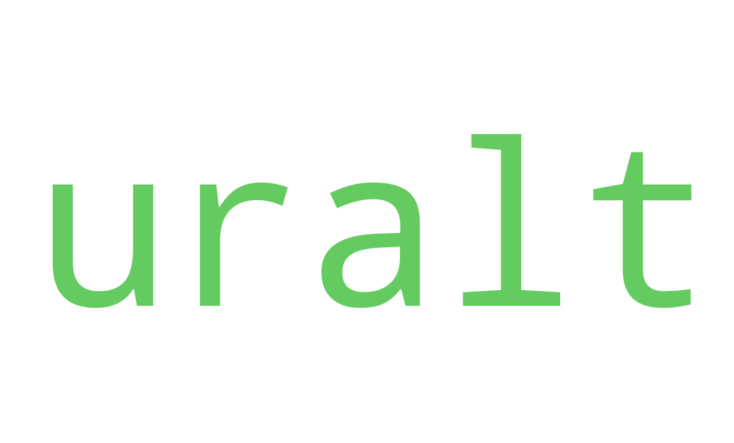

Total no of Words in cluster 2 is 3


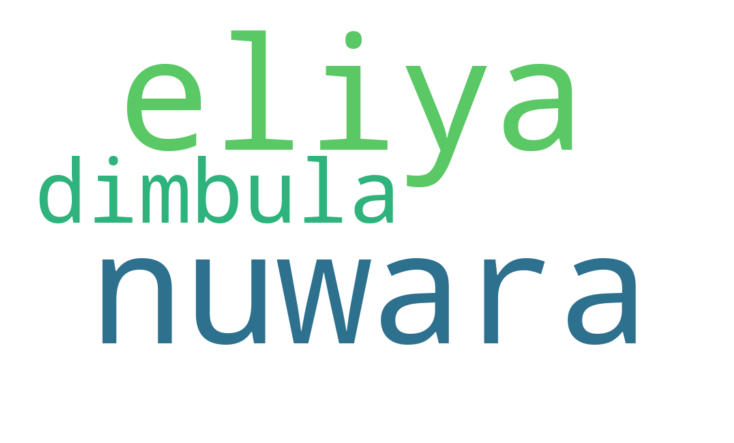

Total no of Words in cluster 3 is 1


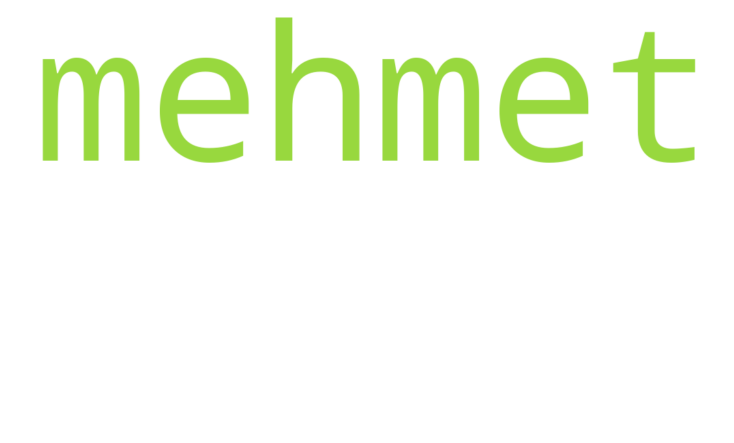

Total no of Words in cluster 4 is 1


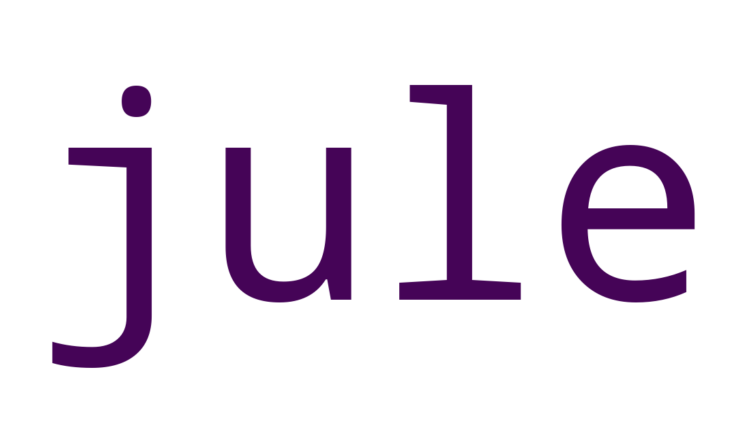

Total no of Words in cluster 5 is 3


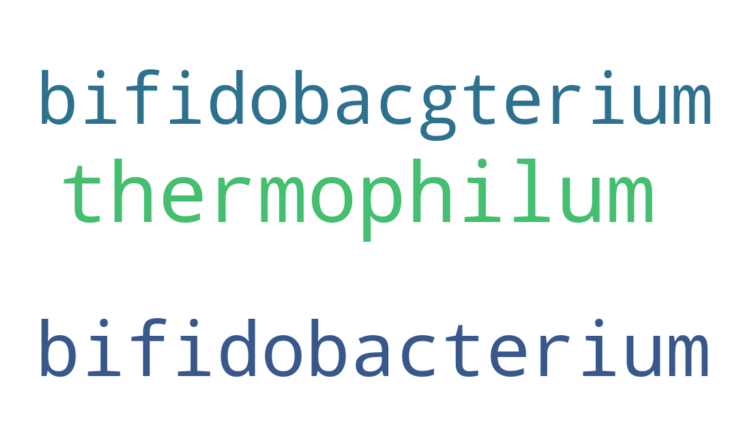

Total no of Words in cluster 6 is 1


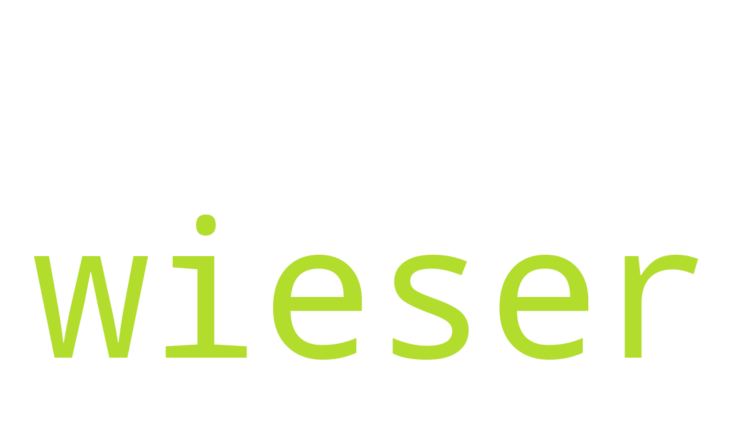

Total no of Words in cluster 7 is 1


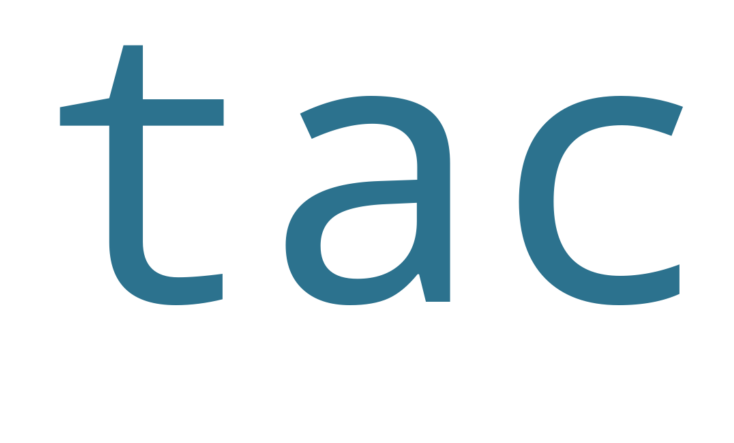

Total no of Words in cluster 8 is 1


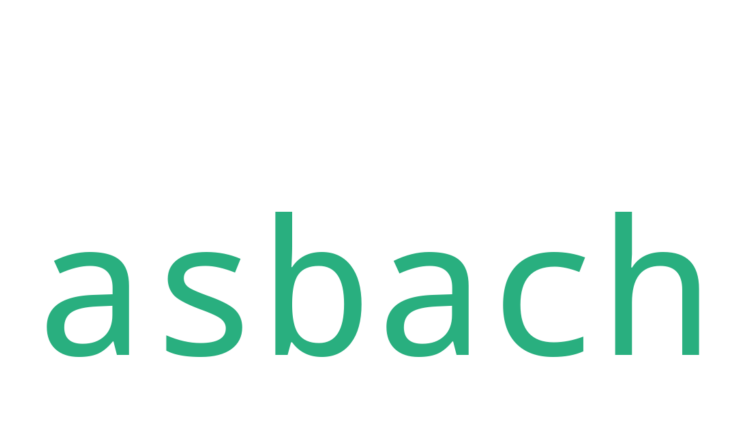

Total no of Words in cluster 9 is 1


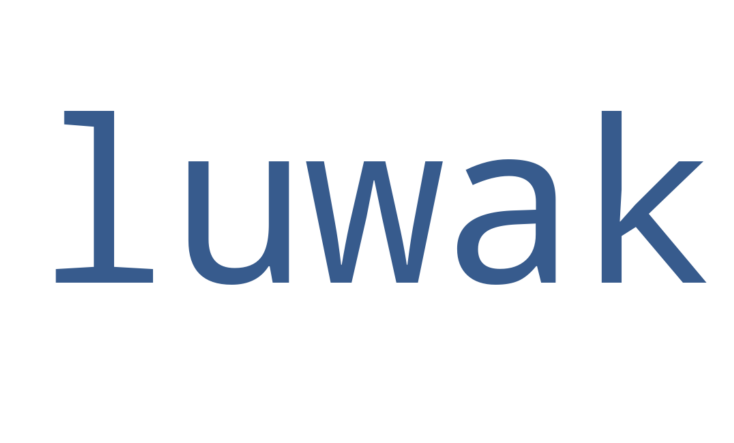

Total no of Words in cluster 10 is 1


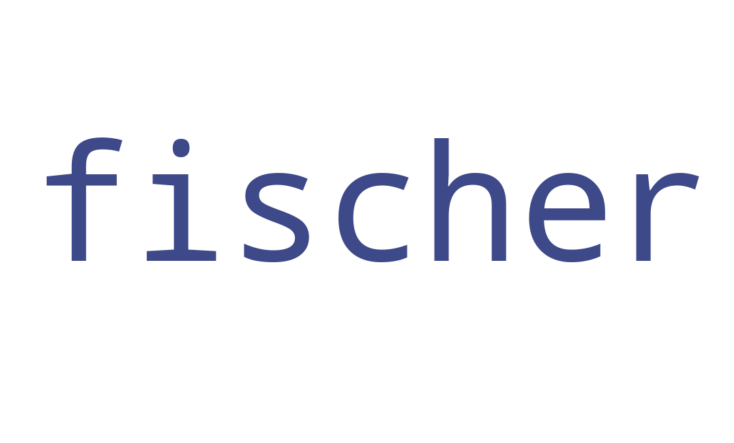

Total no of Words in cluster 11 is 2


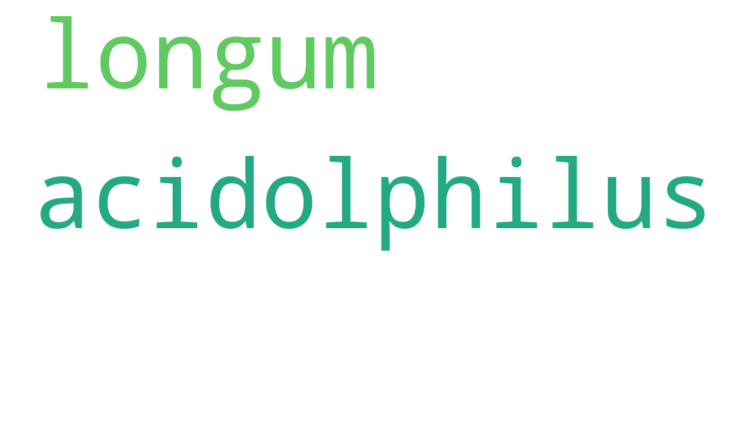

In [21]:
for i in range(model.n_clusters):
    l=list()
    
    # Group at each label 
    label = df.groupby(["Cluster_labels"]).groups[i]
    
    for j in range(len(label)):
        l.append(df.loc[label[j]]["Words"])
    print("Total no of Words in cluster {} is {}".format(i,len(label)))
    Word_Cloud(l)

### Create the Cosine Similarity matrix 

In [22]:
SVD_DF = pd.DataFrame(svd_matrix, index=co_matrix.index)
SVD_DF.head()

,0,1,2,3,4,5,6,7,8,9,...,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998
circulatori,-4.845491e-15,7.234432e-16,3.979309e-15,1.828163e-17,2.631942e-17,3.720469e-16,1.615732e-16,-4.928113e-18,-2.561086e-16,8.581383e-18,...,-1.427609e-18,-1.659540e-17,3.455127e-17,-1.561475e-17,-2.213630e-17,-8.382286e-18,2.780092e-17,-1.367006e-17,3.016057e-17,-1.183002e-17
niederegg,-4.505993e-15,-6.901532e-15,6.954971e-15,2.966494e-16,4.757325e-16,-1.141843e-14,1.021558e-01,-1.526909e-15,-5.551801e-16,-5.383455e-16,...,1.472728e-33,-2.376316e-34,4.244227e-34,-3.343153e-33,3.029243e-35,1.170915e-33,7.382885e-33,3.725634e-33,-1.561730e-33,-1.131228e-33
nile,3.490555e-16,-4.148997e-16,1.280014e-15,-5.162675e-16,4.143736e-16,1.566999e-16,-8.560301e-17,-2.051829e-19,-2.166478e-16,5.314556e-16,...,-1.206309e-32,1.503445e-32,-9.026075e-34,3.199717e-33,1.814454e-33,3.350324e-32,-2.152021e-32,-2.292292e-33,-1.083755e-32,-7.631185e-33
calabria,2.789408e-16,4.419285e-17,-7.267655e-17,-1.408123e-15,3.798918e-15,9.311061e-16,-3.132747e-15,-5.286803e-15,-6.254263e-15,-4.601201e-16,...,7.191237e-18,-6.631601e-18,1.449119e-18,2.523290e-18,1.183230e-17,-1.743357e-17,1.826077e-18,5.593909e-18,3.271976e-18,1.232352e-18
aril,3.581611e-16,1.951675e-16,-7.362645e-16,-2.283839e-15,-1.121689e-15,9.421691e-15,1.722078e-15,6.082137e-15,-1.300207e-14,-3.818235e-16,...,1.210630e-17,-1.611084e-18,-9.340215e-18,2.751334e-18,1.160188e-17,-1.167582e-17,4.797390e-19,1.198247e-17,2.400448e-18,-2.346362e-19


In [23]:
sim_matrix = pd.DataFrame(cosine_similarity(SVD_DF), index=co_matrix.index, columns=co_matrix.index)
vocab = list(sim_matrix.index)
sim_matrix.head()

,circulatori,niederegg,nile,calabria,aril,traditionalist,nina,nishiki,eliya,elkhound,...,pare,gravit,peoni,vermouth,referenc,quirk,gentleman,pester,eucalyptus,groggi
circulatori,1.000000,-1.099998e-01,5.028762e-03,-0.041672,0.011708,5.078156e-02,-0.022380,0.019616,-4.818881e-03,-0.052871,...,0.0,0.0,0.0,7.737038e-03,6.375276e-04,0.0,1.077240e-02,2.190542e-02,-1.123854e-02,4.074676e-03
niederegg,-0.110000,1.000000e+00,-1.663682e-16,-0.001813,0.003989,-4.797430e-17,-0.004167,0.089602,-1.335866e-16,0.033297,...,0.0,0.0,0.0,-5.839358e-17,1.071618e-16,0.0,-3.030268e-16,3.819790e-16,-1.001527e-16,1.472309e-16
nile,0.005029,-1.663682e-16,1.000000e+00,-0.028114,0.009866,9.714451e-17,0.034043,-0.026125,1.571691e-16,0.025244,...,0.0,0.0,0.0,1.114560e-16,-3.101966e-17,0.0,-1.395620e-17,7.665711e-17,-5.762119e-17,-2.051742e-16
calabria,-0.041672,-1.813339e-03,-2.811423e-02,1.000000,0.253732,3.880262e-02,-0.030994,-0.086661,-1.777869e-02,-0.039692,...,0.0,0.0,0.0,1.133527e-02,-1.879997e-03,0.0,3.378892e-02,1.154431e-03,3.327396e-03,2.650422e-03
aril,0.011708,3.988930e-03,9.865688e-03,0.253732,1.000000,5.176707e-03,-0.031837,0.452409,-1.120639e-03,-0.631176,...,0.0,0.0,0.0,-1.760538e-02,9.701771e-04,0.0,-3.438207e-03,1.088080e-03,2.025251e-03,8.782306e-04


In [26]:
def print_similar_words(query):
    print(f'Top 10 similar words to "{query}" :-\n')
    top_idx = np.argsort(sim_matrix[query].values)[1:11]
    [print(vocab[i], sim_matrix[query].iloc[i]) for i in top_idx]

print_similar_words('nile')

Top 10 similar words to "nile" :-

wakeup -0.1323320825023048
christ -0.12979734014406835
gloopi -0.1290928342170854
suchard -0.12170926397399902
havarti -0.10870374554948284
flashlight -0.10429083574919273
inka -0.1042587798423363
cocao -0.10379368858523001
mailman -0.1008051347065944
personn -0.0977733960311233


### Conclusion 

1. I have used 100 K Data Points.

2. Calculated co-variance matrix and applied TruncatedSvd for dimension reduction .

3. I applied Kmeans clustering algorithm on data obtained after performing TruncatedSvd. 